In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [82]:
tree = pd.read_csv('tree.csv')
tree = tree.drop('Adult', axis = 1)
tree.head()

,Unnamed: 0,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Sterile,Conspecific,Myco,SoilMyco,PlantDate,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Alive
0,0,1,C,Acer saccharum,0.106,Med,2017,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,6/11/18,22.00,NaN,-0.56,13.86,12.15,4,14.0,1.0,0,Dead
1,1,1,C,Quercus alba,0.106,Med,2017,Quercus rubra,Non-Sterile,Heterospecific,EMF,EMF,5/25/18,15.82,31.0700,5.19,20.52,19.29,33,115.5,0.0,0,Alive
2,2,1,C,Quercus rubra,0.106,Med,2017,Prunus serotina,Non-Sterile,Heterospecific,EMF,AMF,5/31/18,24.45,28.1900,3.36,24.74,15.01,18,63.0,1.0,0,Dead
3,3,7,D,Acer saccharum,0.080,Med,2016,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,6/11/18,22.23,26.1425,-0.71,14.29,12.36,4,14.0,1.0,0,Dead
4,4,14,A,Acer saccharum,0.060,Low,2017,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,6/11/18,21.15,24.0950,-0.58,10.85,11.20,4,14.0,1.0,0,Dead


In [83]:
def unique(lists):
    unique_list = pd.Series(lists).drop_duplicates().tolist()
    for x in unique_list:
        print(x)

In [84]:
subplot = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
tree['Subplot'] = tree['Subplot'].map(subplot)

species = {'Acer saccharum': 1, 'Quercus alba': 2, 'Quercus rubra': 3, 'Prunus serotina': 4}
tree['Species'] = tree['Species'].map(species)

light = {'Low': 1, 'Med': 2, 'High': 3}
tree['Light_Cat'] = tree['Light_Cat'].map(light)

soil = {'Prunus serotina': 1, 'Quercus rubra': 2, 'Acer rubrum': 3, 'Populus grandidentata': 4,
        'Sterile': 5, 'Acer saccharum': 6, 'Quercus alba': 7}
tree['Soil'] = tree['Soil'].map(soil)

sterile = {'Non-Sterile': 0, 'Sterile': 1}
tree['Sterile'] = tree['Sterile'].map(sterile)

conspecific = {'Sterilized': 1, 'Heterospecific': 2, 'Conspecific': 3}
tree['Conspecific'] = tree['Conspecific'].map(conspecific)

myco = {'AMF': 1, 'EMF': 2}
tree['Myco'] = tree['Myco'].map(myco)

soilmyco = {'AMF': 1, 'EMF': 2, 'Sterile': 3}
tree['SoilMyco'] = tree['SoilMyco'].map(soilmyco)

alive = {'Alive': 1, 'Dead': 0}
tree['Alive'] = tree['Alive'].map(alive)

In [85]:
tree['PlantDate'] = pd.to_datetime(tree['PlantDate'])

def date_to_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 1
    elif 6 <= month <= 8:
        return 2
    elif 9 <= month <= 11:
        return 3
    else:
        return 4
    
tree['Season'] = tree['PlantDate'].apply(date_to_season)
tree = tree.drop('PlantDate', axis = 1)

In [86]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   2783 non-null   int64  
 1   Plot         2783 non-null   int64  
 2   Subplot      2783 non-null   int64  
 3   Species      2783 non-null   int64  
 4   Light_ISF    2783 non-null   float64
 5   Light_Cat    2783 non-null   int64  
 6   Core         2783 non-null   int64  
 7   Soil         2783 non-null   int64  
 8   Sterile      2783 non-null   int64  
 9   Conspecific  2783 non-null   int64  
 10  Myco         2783 non-null   int64  
 11  SoilMyco     2783 non-null   int64  
 12  AMF          2783 non-null   float64
 13  EMF          2782 non-null   float64
 14  Phenolics    2783 non-null   float64
 15  Lignin       2783 non-null   float64
 16  NSC          2783 non-null   float64
 17  Census       2783 non-null   int64  
 18  Time         2783 non-null   float64
 19  Event 

In [87]:
pd.set_option('display.max_columns', None)
column_to_move = 'Alive'
tree['Alive'] = tree.pop(column_to_move)
tree.head()

,Unnamed: 0,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Sterile,Conspecific,Myco,SoilMyco,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Season,Alive
0,0,1,3,1,0.106,2,2017,1,0,2,1,1,22.00,NaN,-0.56,13.86,12.15,4,14.0,1.0,0,2,0
1,1,1,3,2,0.106,2,2017,2,0,2,2,2,15.82,31.0700,5.19,20.52,19.29,33,115.5,0.0,0,1,1
2,2,1,3,3,0.106,2,2017,1,0,2,2,1,24.45,28.1900,3.36,24.74,15.01,18,63.0,1.0,0,1,0
3,3,7,4,1,0.080,2,2016,1,0,2,1,1,22.23,26.1425,-0.71,14.29,12.36,4,14.0,1.0,0,2,0
4,4,14,1,1,0.060,1,2017,1,0,2,1,1,21.15,24.0950,-0.58,10.85,11.20,4,14.0,1.0,0,2,0


In [88]:
X = tree.iloc[:, 0:23]
y = tree.iloc[:, -1]
y_label = y.values

columns_list = X.columns.tolist()
tree = pd.DataFrame(X, columns = columns_list)
tree['Alive'] = y_label
tree.groupby('Alive').mean() 

,Unnamed: 0,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Sterile,Conspecific,Myco,SoilMyco,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Season
Alive,,,,,,,,,,,,,,,,,,,,,,
0,1396.76178,9.596859,2.575044,2.482548,0.085197,1.737347,2016.634380,4.015271,0.151832,1.993455,1.354712,1.730366,21.029756,26.860858,1.515611,14.620803,13.408944,11.486475,40.202661,0.692711,0.307155,1.624346
1,1364.10387,9.397149,2.570265,2.511202,0.088088,1.798371,2016.716904,3.808554,0.152749,1.955193,1.957230,1.704684,18.327882,27.355211,3.881976,21.076619,18.003992,33.000000,115.500000,0.000000,0.000000,1.083503


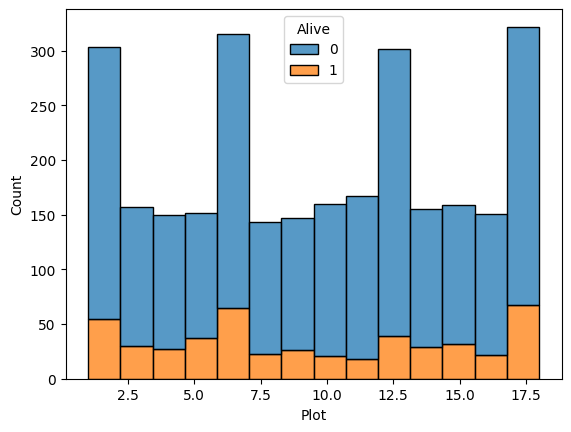

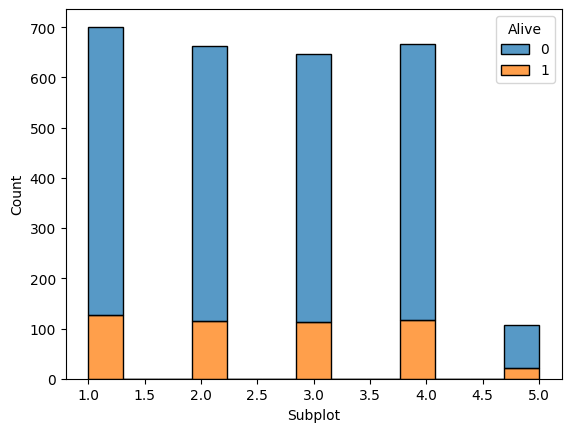

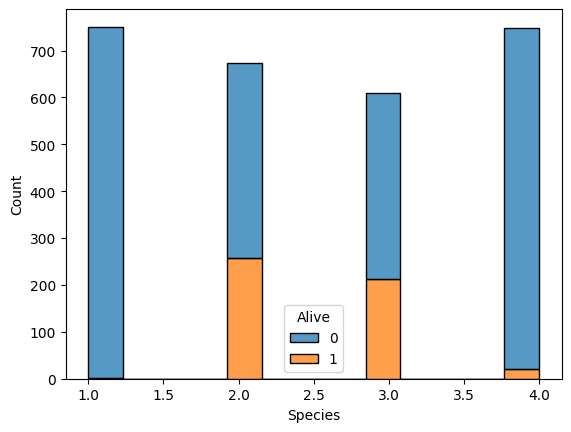

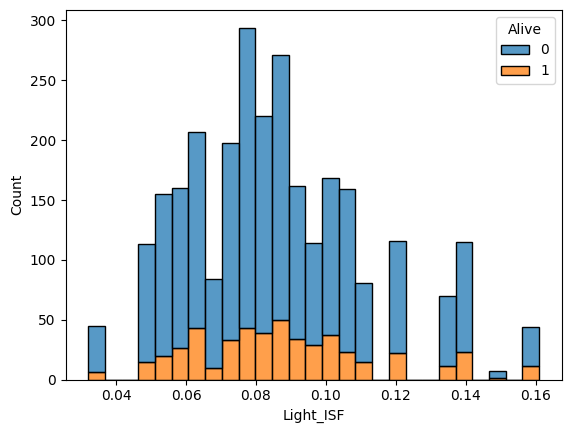

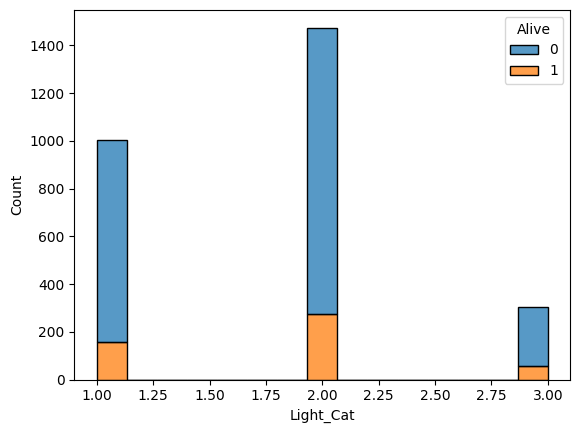

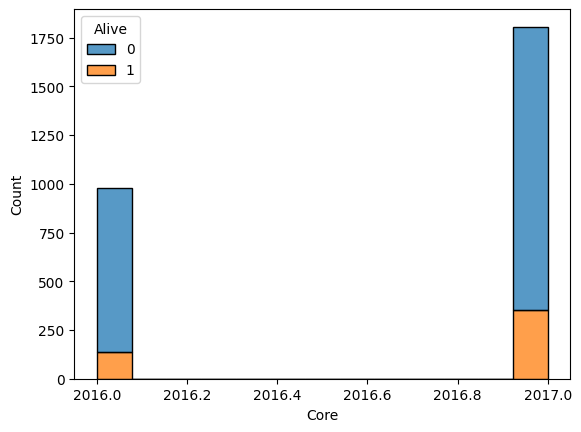

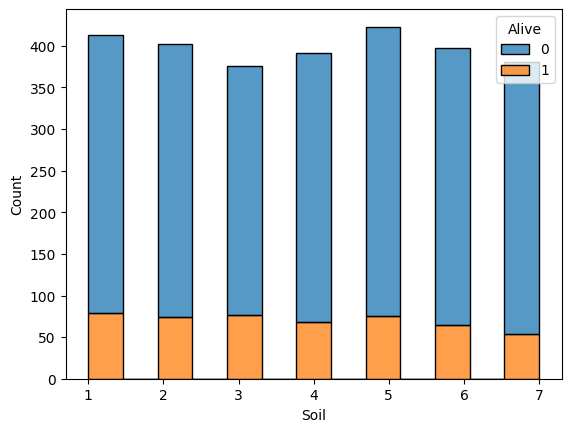

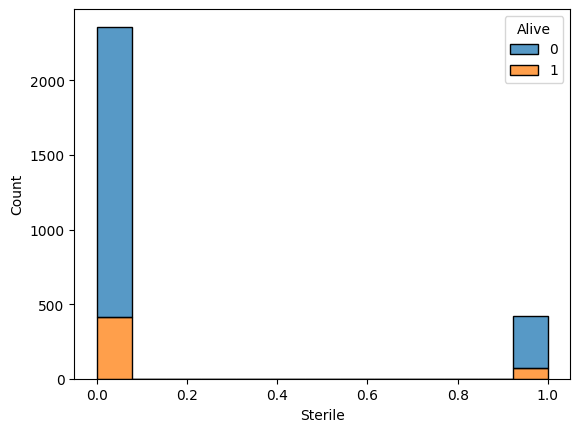

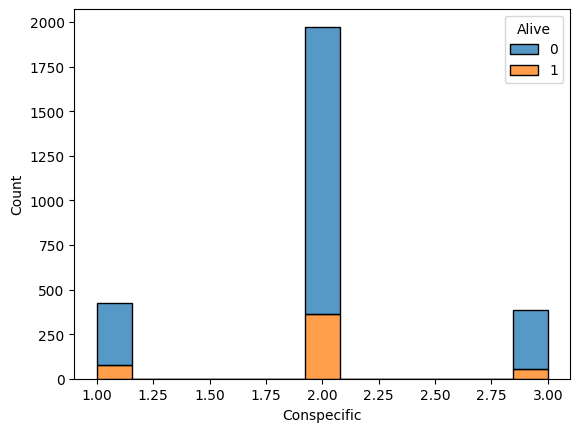

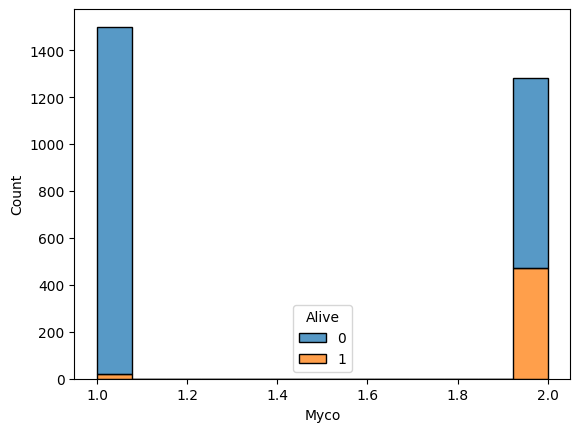

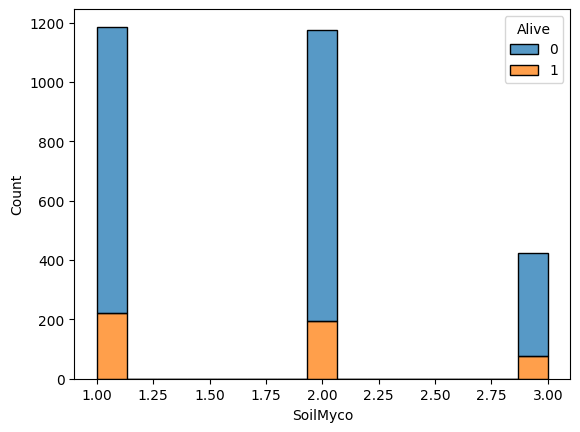

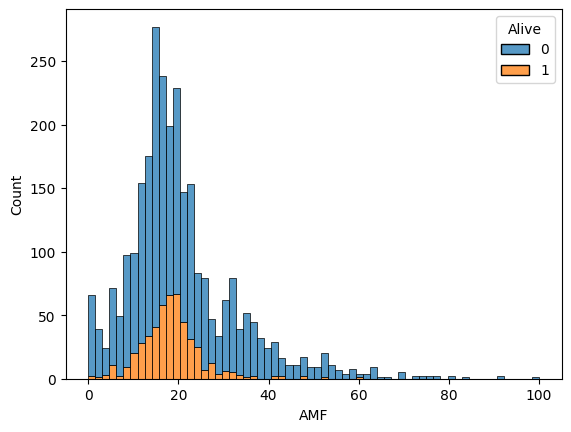

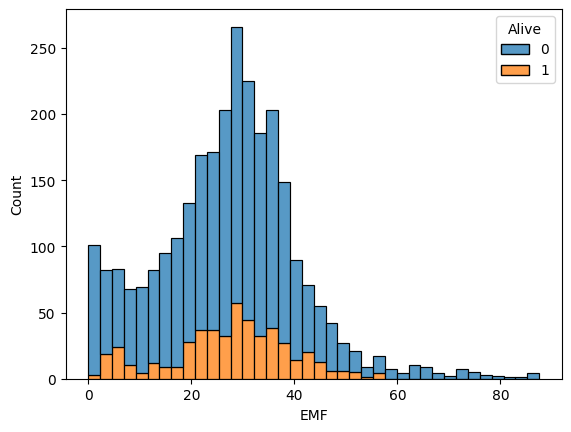

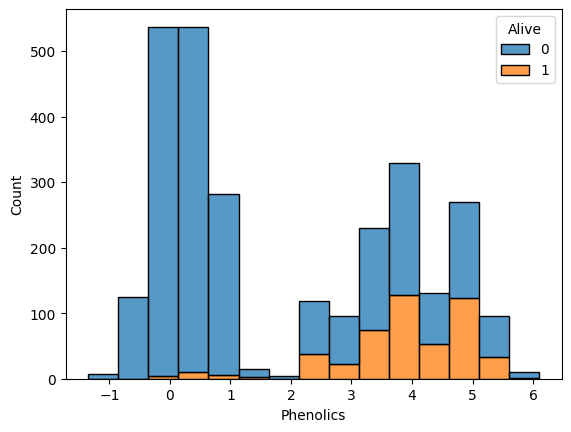

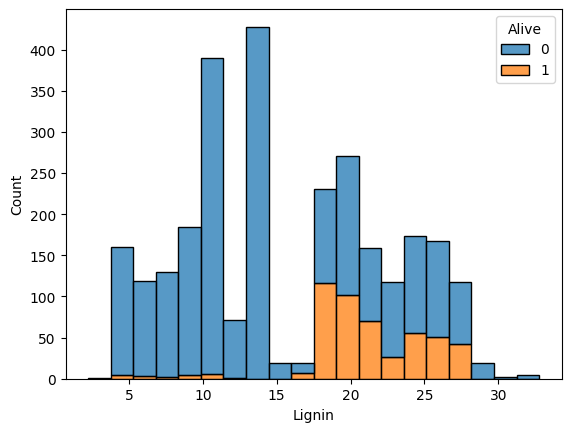

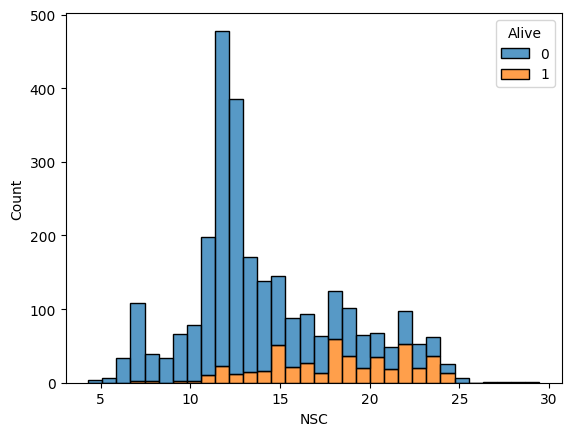

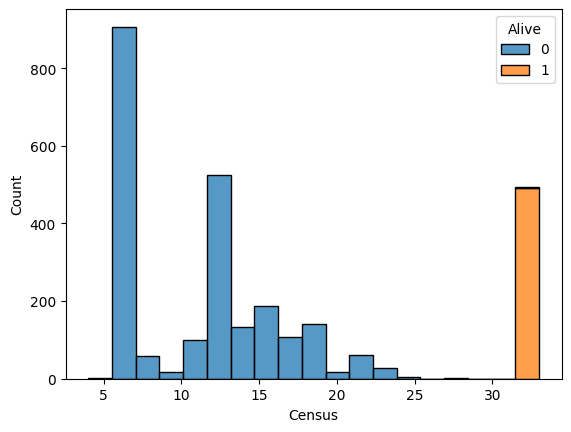

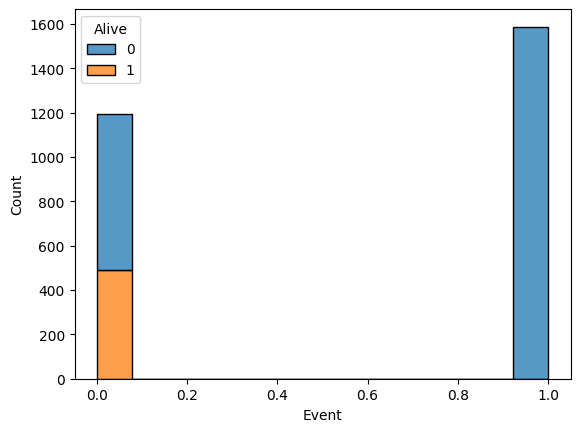

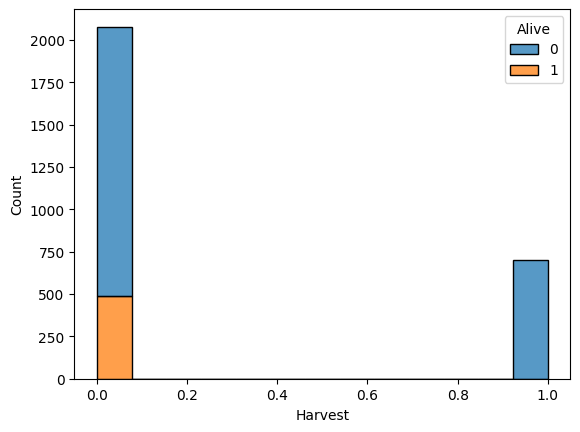

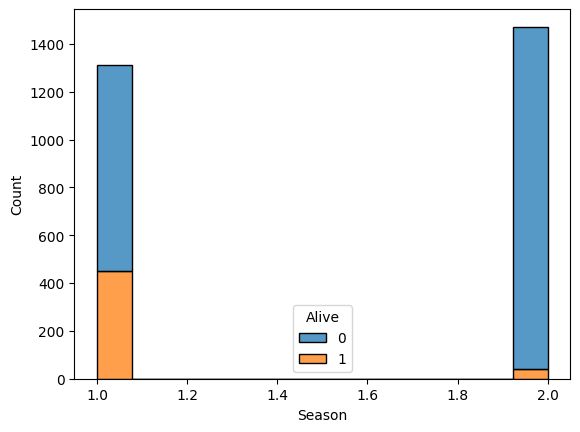

In [89]:
sb.histplot(data = tree, x = "Plot", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Subplot", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Species", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Light_ISF", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Light_Cat", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Core", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Soil", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Sterile", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Conspecific", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Myco", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "SoilMyco", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "AMF", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "EMF", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Phenolics", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Lignin", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "NSC", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Census", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Event", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Harvest", hue = "Alive", multiple = "stack")
plt.show()
sb.histplot(data = tree, x = "Season", hue = "Alive", multiple = "stack")
plt.show()

In [90]:
X = tree.iloc[:, 0:23]
y = tree.iloc[:, -1]
y_label = y.values

columns_list = X.columns.tolist()
tree = pd.DataFrame(X, columns = columns_list)
tree['Alive'] = y_label
tree.groupby('Alive').mean() 

,Unnamed: 0,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Sterile,Conspecific,Myco,SoilMyco,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Season
Alive,,,,,,,,,,,,,,,,,,,,,,
0,1396.76178,9.596859,2.575044,2.482548,0.085197,1.737347,2016.634380,4.015271,0.151832,1.993455,1.354712,1.730366,21.029756,26.860858,1.515611,14.620803,13.408944,11.486475,40.202661,0.692711,0.307155,1.624346
1,1364.10387,9.397149,2.570265,2.511202,0.088088,1.798371,2016.716904,3.808554,0.152749,1.955193,1.957230,1.704684,18.327882,27.355211,3.881976,21.076619,18.003992,33.000000,115.500000,0.000000,0.000000,1.083503


In [91]:
segment1 = tree[tree['Lignin'] <= 15]
segment2 = tree[tree['Lignin'] > 15]
fulldata = tree
mms = MinMaxScaler()

In [92]:
#Full model
X_full = fulldata.iloc[:, 0:23] 
y_full = fulldata.iloc[:, -1]
X_full = mms.fit_transform(X_full)
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, 
                                                                        y_full, 
                                                                        train_size = 0.5, 
                                                                        stratify = y_full, 
                                                                        random_state = 0)
print(fulldata.groupby('Alive').count())

       Unnamed: 0  Plot  Subplot  Species  Light_ISF  Light_Cat  Core  Soil  \
Alive                                                                         
0            2292  2292     2292     2292       2292       2292  2292  2292   
1             491   491      491      491        491        491   491   491   

       Sterile  Conspecific  Myco  SoilMyco   AMF   EMF  Phenolics  Lignin  \
Alive                                                                        
0         2292         2292  2292      2292  2292  2291       2292    2292   
1          491          491   491       491   491   491        491     491   

        NSC  Census  Time  Event  Harvest  Season  
Alive                                              
0      2292    2292  2292   2291     2292    2292  
1       491     491   491    491      491     491  


1.0


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

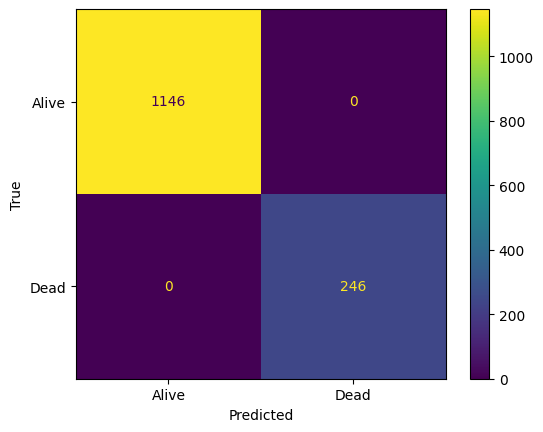

In [93]:
#Full model Tree
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(X_full_train, y_full_train)
y_pred_full =clf.predict(X_full_test)

print(accuracy_score(y_full_test,y_pred_full))
cf_matrix = confusion_matrix(y_full_test,y_pred_full)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = ['Alive', 'Dead'])
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel = 'True')

In [94]:
#Segment 1 model: low light ISF
X_low = segment1.iloc[:, 0:23] 
y_low = segment1.iloc[:, -1]
X_low = mms.fit_transform(X_low)
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low,
                                                                    y_low,
                                                                    train_size = 0.5,
                                                                    stratify = y_low, 
                                                                    random_state = 0)
print(segment1.groupby('Alive').count())

       Unnamed: 0  Plot  Subplot  Species  Light_ISF  Light_Cat  Core  Soil  \
Alive                                                                         
0            1476  1476     1476     1476       1476       1476  1476  1476   
1              21    21       21       21         21         21    21    21   

       Sterile  Conspecific  Myco  SoilMyco   AMF   EMF  Phenolics  Lignin  \
Alive                                                                        
0         1476         1476  1476      1476  1476  1475       1476    1476   
1           21           21    21        21    21    21         21      21   

        NSC  Census  Time  Event  Harvest  Season  
Alive                                              
0      1476    1476  1476   1476     1476    1476  
1        21      21    21     21       21      21  


1.0


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

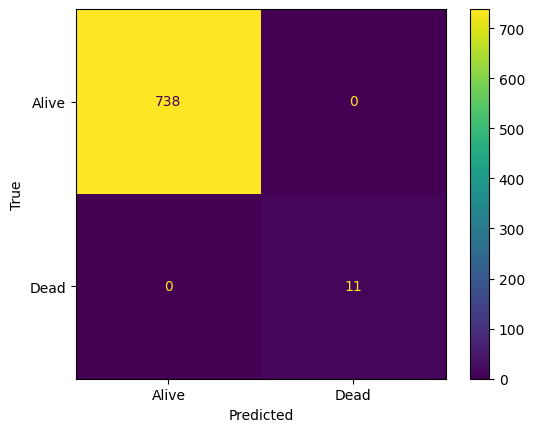

In [95]:
#Segment 1 model tree
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(X_low_train, y_low_train)
y_pred_low = clf.predict(X_low_test)

print(accuracy_score(y_low_test,y_pred_low))
cf_matrix = confusion_matrix(y_low_test,y_pred_low)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = ['Alive', 'Dead'])
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel = 'True')

In [96]:
#Segment 2 model: higher light ISF
X_high = segment2.iloc[:, 0:23] 
y_high = segment2.iloc[:, -1]
X_high = mms.fit_transform(X_high)
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high,
                                                                        y_high,
                                                                        train_size = 0.5,
                                                                        stratify = y_high,
                                                                        random_state = 0)
print(segment2.groupby('Alive').count())

       Unnamed: 0  Plot  Subplot  Species  Light_ISF  Light_Cat  Core  Soil  \
Alive                                                                         
0             816   816      816      816        816        816   816   816   
1             470   470      470      470        470        470   470   470   

       Sterile  Conspecific  Myco  SoilMyco  AMF  EMF  Phenolics  Lignin  NSC  \
Alive                                                                           
0          816          816   816       816  816  816        816     816  816   
1          470          470   470       470  470  470        470     470  470   

       Census  Time  Event  Harvest  Season  
Alive                                        
0         816   816    815      816     816  
1         470   470    470      470     470  


0.9984447900466563


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

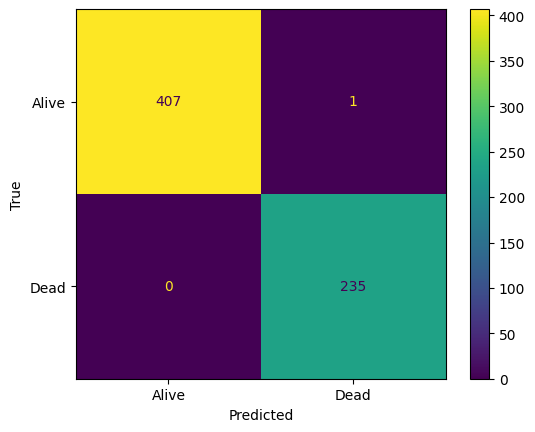

In [97]:
#Segment 2 model Tree
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(X_high_train, y_high_train)
y_pred_high = clf.predict(X_high_test)

print(accuracy_score(y_high_test,y_pred_high))
cf_matrix = confusion_matrix(y_high_test,y_pred_high)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = ['Alive', 'Dead'])
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel = 'True')

In [98]:
X_full = fulldata.iloc[:, 0:23] 
clf = KMeans(n_clusters = 3)
clf.fit(X_full)
labels = clf.predict(X_full)

tree['Cluster'] = labels

segment1_clust = tree[tree['Cluster'] == 0]
segment2_clust = tree[tree['Cluster'] == 1]
segment3_clust = tree[tree['Cluster'] == 2]
fulldata = tree
print(tree.groupby('Cluster').mean())

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values